# Writing a model

This example shows you how to write models (or model wrappers) that can be used with Pints.

Pints is intended to work with a wide range of models, and assumes as little as possible about the model's form.
Specifically, a "model" in Pints is anything that implements the [ForwardModel interface](http://pints.readthedocs.io/en/latest/core_classes_and_methods.html#forward-model).
In other words, it's anything that can take a parameter vector $(\boldsymbol{\theta})$ and a sequence of times $(\mathbf{t})$ as an input, and then return a vector of simulated values $(\mathbf{y})$:

$$f(\boldsymbol{\theta}, \mathbf{t}) \rightarrow \mathbf{y}$$

This might not match well with other ideas of a "model".
For example, if you're modelling something using ODEs, Pints will regard the combination of the ODEs _and an ODE solver_ as a "forward model".

In the example below, we define a system of ODEs (modelling a simple chemical reaction) and use [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) to solve it.
We then wrap everything in a `pints.ForwardModel` class, and use a Pints optimisation to find the best matching parameters.

## Solving a system of ODEs

First, we define an ODE. In this example we'll use a model of a reversible chemical reaction:

$$\dot{y}(t) = k_1 (1 - y) - k_2 y,$$

where $k_1$ represents a forward reaction rate, $k_2$ is the backward reaction rate, and $y$ represents the concentration of a chemical solute.

Next, we write a Python function `r` that represents the right-hand side of this ODE, choose a set of parameters and initial conditions, and solve using SciPy.

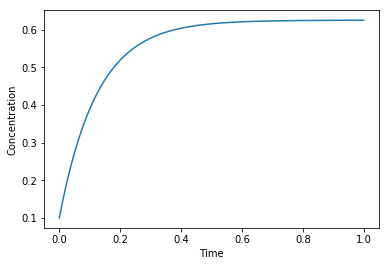

In [10]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as pl
from scipy.integrate import odeint

# Define the right-hand side of a system of ODEs
def r(y, t, p):
    k1 = p[0] # Forward reaction rate
    k2 = p[1] # Backward reaction rate
    dydt = k1 * (1 - y) - k2 * y
    return dydt

# Run an example simulation
p = [5, 3]    # parameters
y0 = 0.1      # initial conditions

# Call odeint, with the parameters wrapped in a tuple
times = np.linspace(0, 1, 1000)
values = odeint(r, y0, times, (p,))

# Reshape odeint's (1000x1) output to (1000,)
values = values.reshape((1000,))

# Plot the results
pl.figure()
pl.xlabel('Time')
pl.ylabel('Concentration')
pl.plot(times, values)
pl.show()

## Writing a wrapper class for Pints

Now we'll wrap the model in a class that extends `pints.ForwardModel`.

It should have two methods: one that runs simulations, and one that tells Pints what the dimension of the model's parameter vector is.

In [2]:
import pints

class ExampleModel(pints.ForwardModel):
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        y0 = 0.1
        def r(y, t, p):
            dydt = (1 - y) * p[0] - y * p[1]
            return dydt
        return odeint(r, y0, times, (parameters,)).reshape(times.shape)
    
    def dimension(self):
        # Return the dimension of the parameter vector
        return 2


# Then create an instance of our new model class
model = ExampleModel()

We can now use this model class to run simulations:

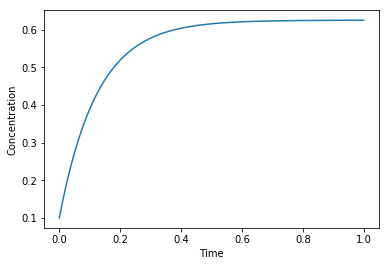

In [9]:
# Run the same simulation using our new model wrapper
values = model.simulate([5, 3], times)

# Plot the results
pl.figure()
pl.xlabel('Time')
pl.ylabel('Concentration')
pl.plot(times, values)
pl.show()

## Running an optimisation problem

Now that our model implements the `pints.ForwardModel` interface, we can use it with Pints tools such as [optimisers](http://pints.readthedocs.io/en/latest/optimisers/index.html) or [MCMC](http://pints.readthedocs.io/en/latest/mcmc/index.html).

In the example below, we use the model to generate test data, add some noise, and then define a score function that characterises the mismatch between model predictions and data. We then use the [SNES](http://pints.readthedocs.io/en/latest/mcmc/index.html) optimiser to estimate the model parameters from the data.

Running in parallel mode with population size 8
1: 1.69373868691
2: 0.995034632864
3: 0.995034632864
20: 0.390330510476
40: 0.390017560455
60: 0.389790109661
80: 0.389789303456
100: 0.389789301323
120: 0.389789301209
140: 0.389789301206
160: 0.389789301206
180: 0.389789301205
200: 0.389789301205
Halting: No significant change for 100 iterations.
210: 0.389789301205
Score at true solution:
0.39232170327
Found solution:          True parameters:
 4.91550120723028794e+00     5.00000000000000000e+00
 2.92662050734065637e+00     3.00000000000000000e+00


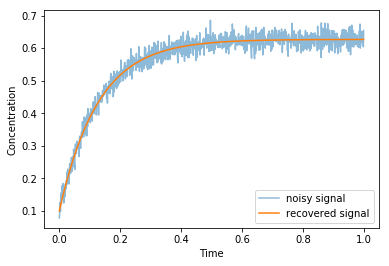

In [8]:
# Define the 'true' parameters
true_parameters = [5, 3]

# Run a simulation to get test data
values = model.simulate(true_parameters, times)

# Add some noise
values += np.random.normal(0, 0.02, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleSeriesProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Select some boundaries
boundaries = pints.Boundaries([0.1, 0.1], [10, 10])

# Perform an optimization using SNES (see docs linked above). 
found_parameters, found_value = pints.snes(score, boundaries)
print('Score at true solution:')
print(score(true_parameters))

print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(true_parameters[k]))

# Plot the results
pl.figure()
pl.xlabel('Time')
pl.ylabel('Concentration')
pl.plot(times, values, alpha=0.5, label='noisy signal')
pl.plot(times, problem.evaluate(found_parameters), label='recovered signal')
pl.legend()
pl.show()